In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

Import IHSG Data

In [2]:
start_date = "2020-01-01"
end_date = "2025-11-05"

df = yf.Ticker("JARR.JK")
df = df.history(start=start_date, end=end_date)
del df["Dividends"]
del df["Stock Splits"]
forecastData = df.copy()
df.tail(20)

,Open,High,Low,Close,Volume
Date,,,,,
2025-10-08 00:00:00+07:00,6175.0,6175.0,6175.0,6175.0,6551000
2025-10-09 00:00:00+07:00,6775.0,6775.0,6775.0,6775.0,3560900
2025-10-10 00:00:00+07:00,7450.0,7450.0,7450.0,7450.0,2009500
2025-10-13 00:00:00+07:00,8175.0,8175.0,8175.0,8175.0,1124500
2025-10-14 00:00:00+07:00,9000.0,9600.0,6950.0,6950.0,11584600
2025-10-15 00:00:00+07:00,5925.0,5925.0,5925.0,5925.0,951800
2025-10-16 00:00:00+07:00,5050.0,5050.0,5050.0,5050.0,1696900
2025-10-17 00:00:00+07:00,4300.0,4490.0,4300.0,4300.0,22029400
2025-10-20 00:00:00+07:00,3660.0,3660.0,3660.0,3660.0,7764300


Close Price Visualitation

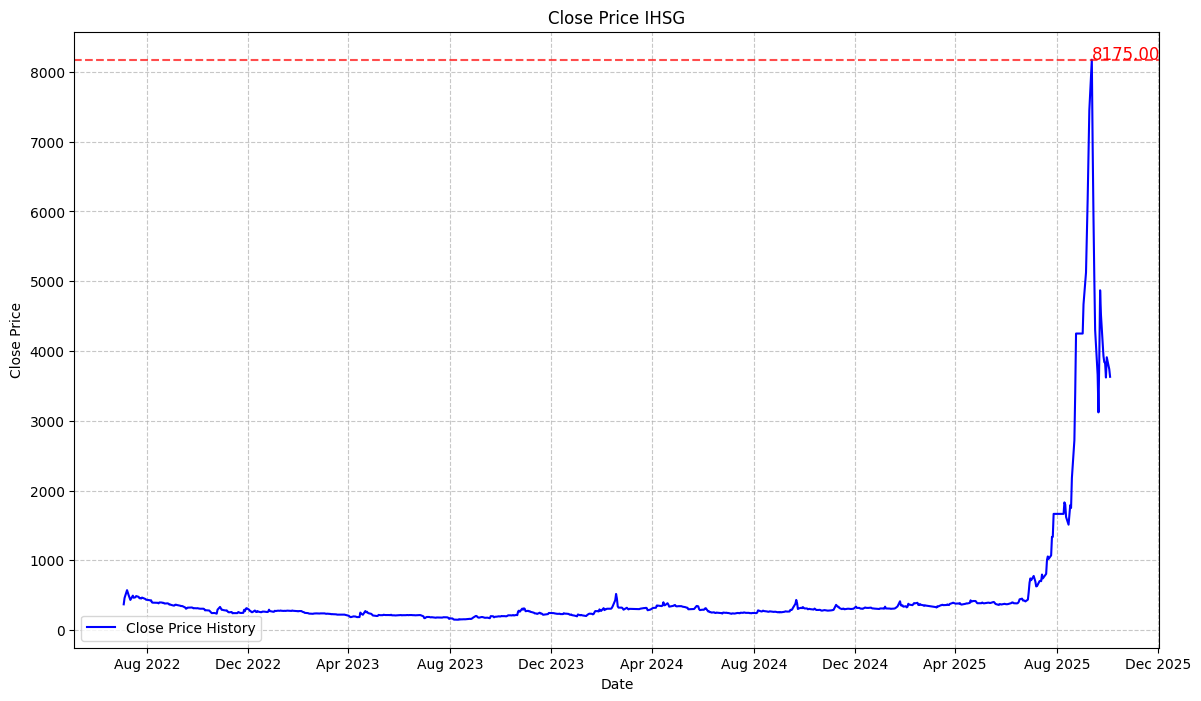

In [3]:
# Close price visualitation

plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=df.index, y='Close', label='Close Price History', color='blue')

max_price = df['Close'].max()
max_price_date = df['Close'].idxmax()

# Annotate the hight price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price IHSG')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Preprocessing

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
scaled_data

array([[2.74988260e-02],
       [3.87929867e-02],
       [5.27879271e-02],
       [4.78774205e-02],
       [4.35807300e-02],
       [3.92840396e-02],
       [3.53556351e-02],
       [4.29669177e-02],
       [3.92840396e-02],
       [4.00206152e-02],
       [4.22303421e-02],
       [4.07571908e-02],
       [3.83019375e-02],
       [3.87929867e-02],
       [3.78108884e-02],
       [3.95295623e-02],
       [3.78108884e-02],
       [3.70743128e-02],
       [3.56011615e-02],
       [3.56011615e-02],
       [3.53556351e-02],
       [3.46190595e-02],
       [3.46190595e-02],
       [3.09361814e-02],
       [3.04451285e-02],
       [3.04451285e-02],
       [3.01996058e-02],
       [3.01996058e-02],
       [3.01996058e-02],
       [2.92175037e-02],
       [3.09361814e-02],
       [3.06906549e-02],
       [2.99540793e-02],
       [3.01996058e-02],
       [2.89719772e-02],
       [2.89719772e-02],
       [2.92175037e-02],
       [2.84809281e-02],
       [2.70077769e-02],
       [2.72533033e-02],


In [5]:
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    for i in range(len(df) - sequence_length):
        sequences.append(df[i:i + sequence_length])
        labels.append(df[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

In [6]:
sequence_length = 30

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [7]:
X_train

array([[[0.02749883],
        [0.03879299],
        [0.05278793],
        ...,
        [0.03019961],
        [0.03019961],
        [0.0292175 ]],

       [[0.03879299],
        [0.05278793],
        [0.04787742],
        ...,
        [0.03019961],
        [0.0292175 ],
        [0.03093618]],

       [[0.05278793],
        [0.04787742],
        [0.04358073],
        ...,
        [0.0292175 ],
        [0.03093618],
        [0.03069065]],

       ...,

       [[0.02111517],
        [0.02111517],
        [0.02111517],
        ...,
        [0.02504358],
        [0.02578015],
        [0.0233249 ]],

       [[0.02111517],
        [0.02111517],
        [0.02160622],
        ...,
        [0.02578015],
        [0.0233249 ],
        [0.02406147]],

       [[0.02111517],
        [0.02160622],
        [0.02062412],
        ...,
        [0.0233249 ],
        [0.02406147],
        [0.02209727]]])

Training Data

In [8]:
model = Sequential()

# First Layer lSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

2025-11-05 22:03:38.139146: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-05 22:03:38.139188: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-05 22:03:38.139194: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-05 22:03:38.139216: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-05 22:03:38.139233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=126, validation_data=(X_test, y_test))

Epoch 1/100


2025-11-05 22:03:39.424324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 1.2810e-04 - val_loss: 0.0695
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.0573e-05 - val_loss: 0.0598
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.9362e-05 - val_loss: 0.0584
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.7711e-05 - val_loss: 0.0504
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.2365e-05 - val_loss: 0.0457
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.7143e-05 - val_loss: 0.0379
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.2293e-05 - val_loss: 0.0321
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8543e-05 - val_loss: 0.0245
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.4674e-05 - val_loss: 0.0197
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.3348e-05 - val_loss: 0.0171
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.4966e-05 - val_loss: 0.0164
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 

Model Evaluation

In [10]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, predictions)
mape = mean_absolute_percentage_error(y_test_scaled, predictions) * 100

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Mean Squared Error: 499497.733818176
Root Mean Squared Error: 706.7515361272135
R2 Score: 0.8581548835062978
Mean Absolute Percentage Error: 12.72781423419684%


Prediction Future IHSG Price in 1 Month

In [11]:
# we choose last 30 days or data ke belakang which the reasons use (-) in sequence_length
last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

X_predict = []
X_predict.append(last_30_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted IHSG Price: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
Predicted IHSG Price: 3383.14208984375


In [12]:
future_days = 30

last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_30_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0, 0])

    new_scaled_data = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)

future_dates = pd.date_range(start=df.index[-1], periods=future_days+1, freq='D')[1:]

future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

Visualitation IHSG Predictions

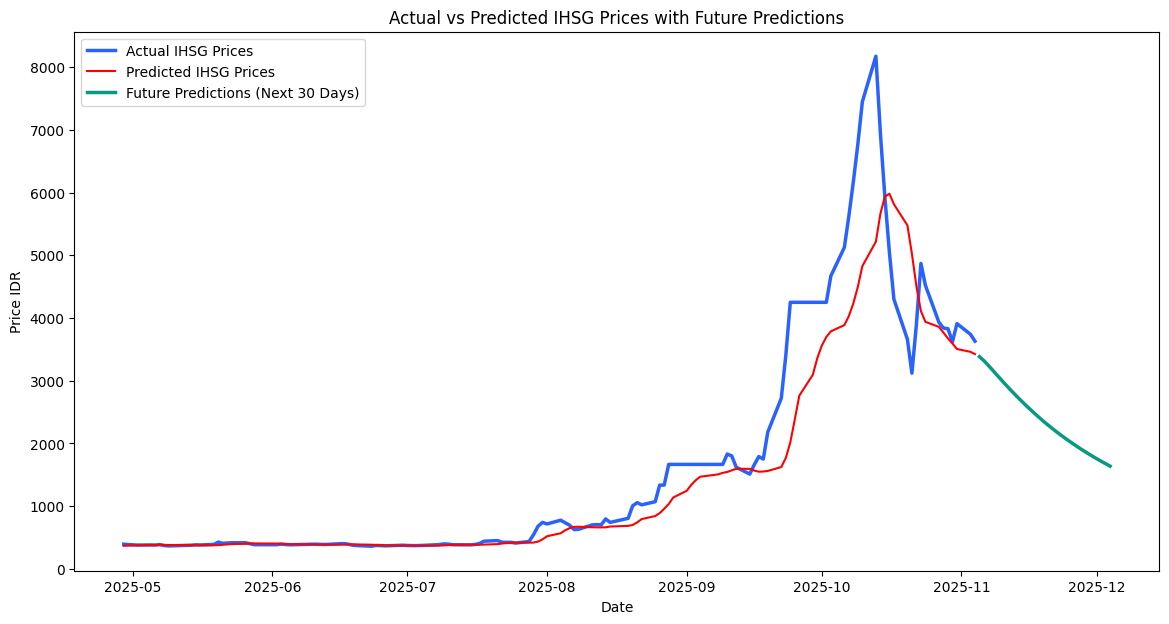

In [13]:
plt.figure(figsize=(14, 7))

plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label='Actual IHSG Prices', color='#2962ff', linewidth=2.5)
plt.plot(df.index[-len(y_test_scaled):], predictions, label='Predicted IHSG Prices', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 30 Days)', color='#089981', linewidth=2.5)

plt.title('Actual vs Predicted IHSG Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price IDR')
plt.legend()
plt.show()

In [14]:
# Transforming into DataFrame with pandas
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions
})

future_predictions_df.tail()

,Date,Predicted Price IHSG
25,2025-11-30 00:00:00+07:00,1799.336426
26,2025-12-01 00:00:00+07:00,1756.982422
27,2025-12-02 00:00:00+07:00,1715.966919
28,2025-12-03 00:00:00+07:00,1676.096802
29,2025-12-04 00:00:00+07:00,1637.468628


In [15]:
# calculate percentage change from the last actual close price
last_actual_price = df['Close'].iloc[-1]
percentage_change = ((future_predictions_df['Predicted Price IHSG'].iloc[-1] - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"

# print the percentage prediction
print(f"Percentage prediction for 30 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 30 days is: loss 54.89%
